In [1]:
import numpy as np
import matplotlib.pyplot as plt

from data_.load_ts import give_ts, data_split_config
from module.rc_class import RC
from module._rc_operations import reservoir
from module.process_ts import process_ts, process_ts_slow

from module._rc_operations import cycle

from module.construct_q import Q_mtx_fast

from module.fourier_motif import find_fourier_motifs
from module.rc_conv_class import rc_conv

from module.util import normalize_columns, sort_columns_by_partial_argmax, reshape, spec_radius
from module.rc_conv_class import conv_main, RidgeReadout

from module.rc_conv_from_before import conv_main_customfit

In [2]:
horizon_list = [48,168, 336, 720, 960]

In [3]:
data_type = ['ecl', 'etth1', 'weather', 'ettm1']

In [4]:
spectral_radius_list = np.array([0.8,0.95,0.985,0.99,1])

In [5]:
results_RMM = []
results_spRMM = []

results_Fourier = []
results_SCR = []

In [6]:
n_res = 97

ridge_coeff = 1e-3
align_flag = False
interval_len = n_res * 2
washout = interval_len # same as look-back, memory tau, etc, 

n_ts = 1
rc_nonlinear = 0

test_flag = 1

linear ? and fit type
0 ridge
0.5080346169818426
0.47172173792710037
0.5080346169818426
linear ? and fit type
0 ridge
0.7097008546121658
0.6886030951859345
0.7097008546121659
linear ? and fit type
0 ridge
0.23069072581927844
0.22450058461850453
0.23069072581927852
linear ? and fit type
0 ridge
0.5423451312578496
0.5461889973156335
0.5423451312578491


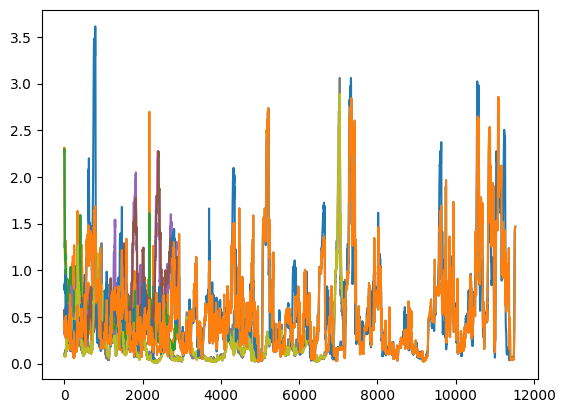

In [7]:


# for horizon in horizon_list:
for time_series_type in data_type:

    horizon = 168
    


    train_size, noise_length, test_size, train_size_conf = data_split_config(time_series_type, interval_len, 1)
    validation_size = noise_length - train_size - interval_len -1 - test_size

    noise_length_h = noise_length
    noise_length += horizon
    noise_length_conf = noise_length_h - interval_len
    noise_length_h = noise_length - horizon

    val_start = train_size + washout + 1

    x_ts, noise_length = give_ts(name = time_series_type, n_ts = n_ts, noise_length = noise_length)
    x_ts = (x_ts - x_ts.mean())/ x_ts.std()
    data = x_ts[0]

    test_flag = 1

    # Threshold of whether we run MLP instead of ridge, seems like ridge is still faster

    n_res_threshold = 100000

    validation_flag = 0

    if validation_flag == 1:
        val_start = train_size + washout +1
        record_start = 0

    #     test_size_val = noise_length - val_start - test_size - horizon
        rang1  =range(val_start, noise_length - test_size-horizon )
    else:
        record_start = validation_size

        val_start = train_size + washout +1  + validation_size
        rang1  =range(val_start, noise_length - horizon )

    ts_pieces, y_pieces, val_pieces, y_val_pieces, test_pieces, y_test_pieces = process_ts_slow(x_ts, interval_len, train_size = train_size ,noise_length = noise_length_h, return_only_ts = 0, horizon = horizon, test_flag = test_flag, test_size = test_size)

    # ts_pieces = ts_pieces[0]
    # y_pieces = y_pieces[0]
    # val_pieces = val_pieces[0]
    # y_val_pieces = y_val_pieces[0]
    # test_pieces = test_pieces[0]
    # y_test_pieces = y_test_pieces[0]
    rc_nonlinear = 0
    fit_type = 'ridge'
    conv_flag = 1

    print('linear ? and fit type')
    print(rc_nonlinear, fit_type)
    rin_input = 0.05

        
    ######### UNIT SP

    # rin_input, spec_rad_input, learning_rate, batch_size, weight_decay = load_cv_param(opted_param, opted_train, horizon, rc_nonlinear, fit_type, conv_flag = 1, title_text = title_text)
    spectral_radius = 1
    # Reservoir matrices

    W = cycle(n_res, spectral_radius = spectral_radius)


    _, Win = reservoir(n_res, 1, rin = rin_input, spectral_radius = spectral_radius, win_rand = 0)
    Qp, phi = Q_mtx_fast(W,Win,interval_len, return_phi = 1)
    motif, motif_weight, _ = np.linalg.svd(Qp, full_matrices=True)

    motif_index = np.where(motif_weight > 1e-14)[0]
    motif = normalize_columns(motif[:,motif_index])
    Nm = min(np.min(motif.shape), interval_len)
    
    Wout, test_loss_motif, _, _ = conv_main_customfit(ts_pieces, motif, y_pieces, test_pieces, y_test_pieces, 
                                                                                  interval_len, ridge_coeff = ridge_coeff, Nm = Nm)
    
    
    spectral_radius = 0.98
    # Reservoir matrices

    W_sp = cycle(n_res, spectral_radius = spectral_radius)


    _, Win_sp = reservoir(n_res, 1, rin = rin_input, spectral_radius = spectral_radius, win_rand = 0)
    Qp_sp, phi_sp = Q_mtx_fast(W_sp,Win_sp,interval_len, return_phi = 1)
    motif_sp, motif_weight_sp, _ = np.linalg.svd(Qp_sp, full_matrices=True)

    motif_index_sp = np.where(motif_weight_sp > 1e-14)[0]
    motif_sp = normalize_columns(motif_sp[:,motif_index_sp])
    Nm_sp = min(np.min(motif_sp.shape), interval_len)
    
    Wout_sp, test_loss_motif_sp, _, _ = conv_main_customfit(ts_pieces, motif_sp, y_pieces, test_pieces, y_test_pieces, 
                                                                                  interval_len, ridge_coeff = ridge_coeff, Nm = Nm_sp)
    
    
    ### Fourier
    unsorted_fourier_basis, fourier_basis = find_fourier_motifs(W ,Win, motif_w_rel_threshold = 1e-13, normalize_flag = False, interval_len=interval_len)
    unsorted_fourier_basis = normalize_columns(unsorted_fourier_basis)
    Nm_fourier = min(np.min(unsorted_fourier_basis.shape), interval_len)

    Wout_fourier, test_loss_fourier, _, _ = conv_main_customfit(ts_pieces, unsorted_fourier_basis, 
                                                         y_pieces, test_pieces, y_test_pieces, 
                                                         interval_len, ridge_coeff = ridge_coeff, Nm = Nm_fourier)
    
    
    results_RMM.append(test_loss_motif)
    results_spRMM.append(test_loss_motif_sp)
    results_Fourier.append(test_loss_fourier)
    
    

In [8]:
print(Nm, Nm_sp, Nm_fourier)

97 97 97


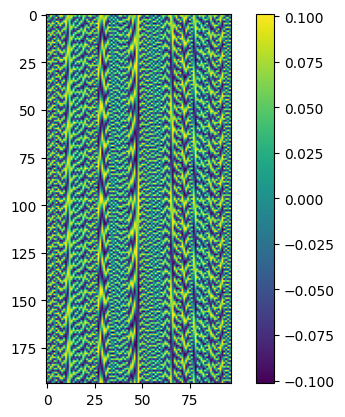

In [9]:
plt.imshow(unsorted_fourier_basis)
plt.colorbar()

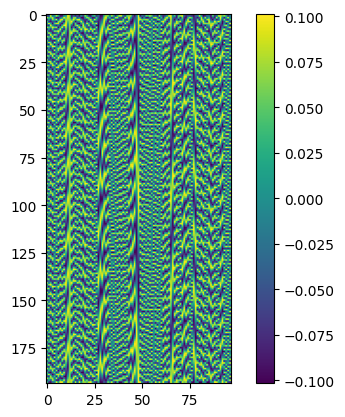

In [10]:
plt.imshow(motif)
plt.colorbar()

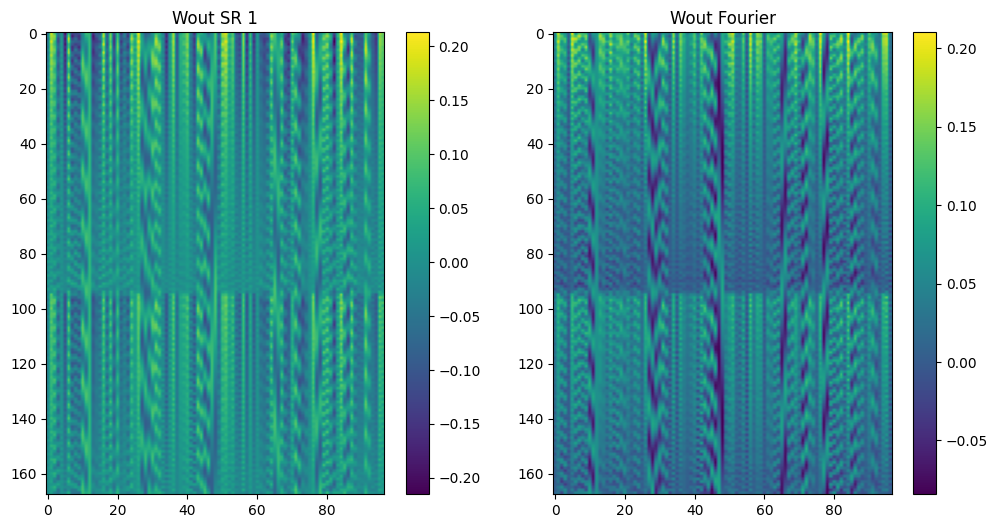

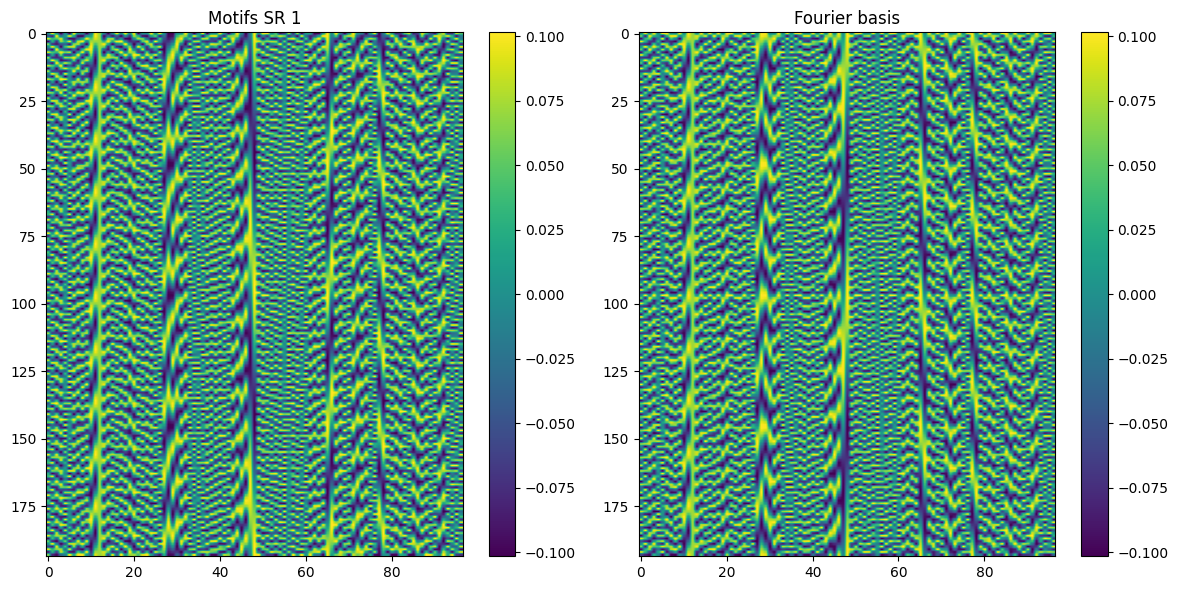

In [11]:
# Step 6: Plot the FFTs
plt.figure(figsize=(12, 6))

# Plot the FFT of the filtered motifs
plt.subplot(1, 2, 1)
plt.imshow(Wout, aspect='auto', cmap='viridis')
plt.title('Wout SR 1')
plt.colorbar()


# Plot the FFT of the corresponding Fourier basis
plt.subplot(1, 2, 2)
plt.imshow(Wout_fourier, aspect='auto', cmap='viridis')
plt.title('Wout Fourier')
plt.colorbar()
plt.show()


plt.figure(figsize=(12, 6))

# Plot the FFT of the filtered motifs
plt.subplot(1, 2, 1)
plt.imshow(motif[:,:n_res], aspect='auto', cmap='viridis')
plt.title('Motifs SR 1')
plt.colorbar()

# Plot the FFT of the corresponding Fourier basis
plt.subplot(1, 2, 2)
plt.imshow(unsorted_fourier_basis[:,:n_res], aspect='auto', cmap='viridis')
plt.title('Fourier basis')
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
Nm_sp

97

In [13]:
try:
    results_Fourier_np = np.array(results_Fourier)
    results_RMM_np = np.array(results_RMM)
    results_spRMM_np = np.array(results_spRMM)
    
    means_RMM = np.mean(results_RMM_np, axis=1)
    std_devs_RMM = np.std(results_RMM_np, axis=1)
    
    means_spRMM = np.mean(results_spRMM_np, axis=1)
    std_devs_spRMM = np.std(results_spRMM_np, axis=1)

    means_Fourier = np.mean(results_Fourier_np, axis=1)
    std_devs_Fourier = np.std(results_Fourier_np, axis=1)

except:
    means_RMM = np.zeros(len(results_RMM))
    std_devs_RMM = np.zeros_like(means_RMM)
    
    means_spRMM = np.zeros(len(results_Fourier))
    std_devs_spRMM = np.zeros_like(means_spRMM)
    
    means_Fourier = np.zeros_like(means_RMM)
    std_devs_Fourier = np.zeros_like(std_devs_RMM)
    
    for i in range(len(results_Fourier)):
        
        means_RMM[i] = np.mean(results_RMM[i])
        std_devs_RMM[i] = np.std(results_RMM[i])
        
        means_spRMM[i] = np.mean(results_spRMM[i])
        std_devs_spRMM[i] = np.std(results_spRMM[i])
        
        means_Fourier[i] = np.mean(results_Fourier[i])
        std_devs_Fourier[i] = np.std(results_Fourier[i])

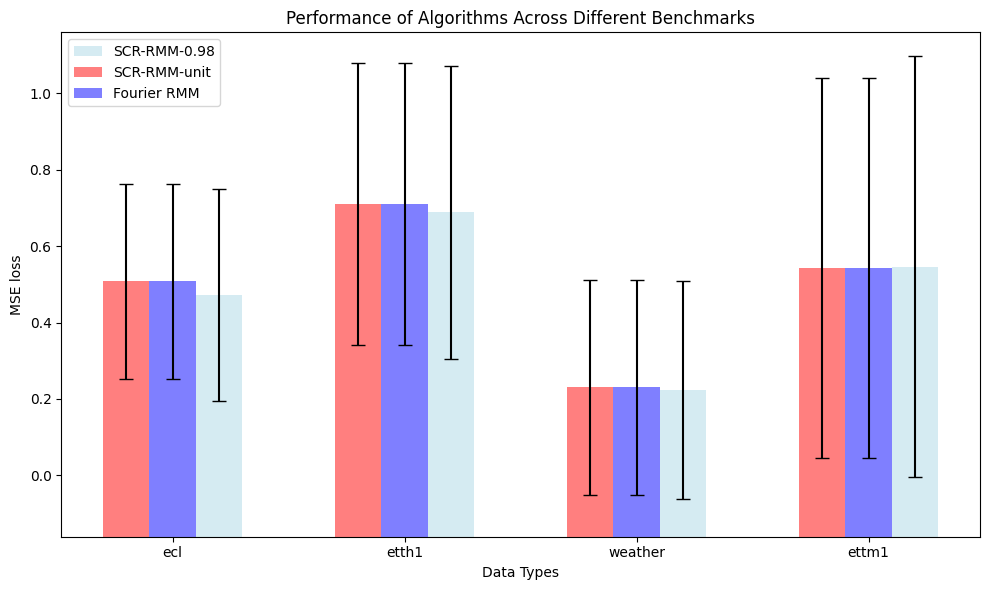

In [15]:
min_val = min(np.min(means_Fourier - std_devs_Fourier), 
              np.min(means_RMM - std_devs_RMM), np.min(means_spRMM - std_devs_spRMM))
y_axis_min = min(0, min_val) - 0.1

#               ,np.min(means_A3 - std_devs_A3))

# means_A3 = np.mean(A3, axis=1)
# std_devs_A3 = np.std(A3, axis=1)

# Set up the plot
plt.figure(figsize=(10, 6))

x = np.arange(len(data_type))  # x locations for the benchmarks
width = 0.2  # Width of the bars


plt.bar(x + width, [y_axis_min ]*len(data_type), width=width, color = 'lightblue', alpha = 0.5)
plt.bar(x - width, [y_axis_min ]*len(data_type), width=width, color = 'red', alpha = 0.5)
plt.bar(x, [y_axis_min]*len(data_type), width=width, color='blue', alpha = 0.5)
# plt.bar(x + width, [y_axis_min]*len(benchmarks), width=width, color='white')

# Creating bar plots for each algorithm
plt.bar(x + width, means_spRMM, width=width, yerr=std_devs_spRMM, capsize=5, label='SCR-RMM-0.98', color = 'lightblue', alpha = 0.5)
plt.bar(x - width, means_RMM, width=width, yerr=std_devs_RMM, capsize=5, label='SCR-RMM-unit', color = 'red', alpha = 0.5)
plt.bar(x, means_Fourier, width=width, yerr=std_devs_Fourier, capsize=5, label='Fourier RMM', color='blue', alpha = 0.5)

# plt.bar(x + width, means_A3, width=width, yerr=std_devs_A3, capsize=5, label='Algorithm 3')

# Setting the x-axis labels and title
plt.xticks(x, data_type)
plt.xlabel('Data Types')
plt.ylabel('MSE loss')
# plt.yscale('log')
plt.title('Performance of Algorithms Across Different Benchmarks')
plt.ylim(bottom=y_axis_min)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/bc/1bx718cj76b7_sg6yjyzrnkc0000gn/T/ipykernel_27053/1801105663.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=1.5)


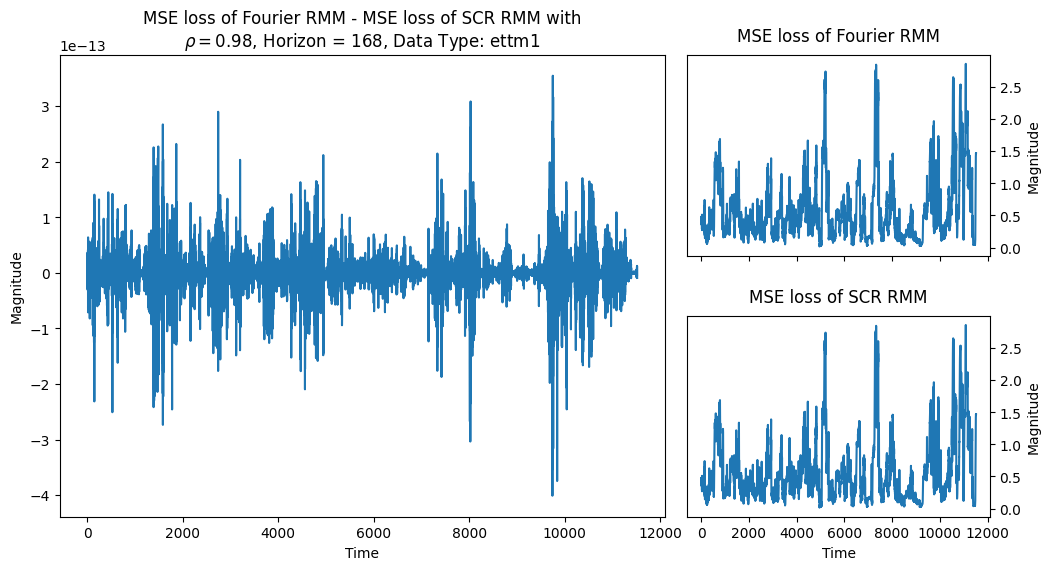

In [30]:
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)

# Large plot on the left (spans two rows)
ax1 = fig.add_subplot(gs[:, 0])  # span all rows of the first column
ax1.plot(test_loss_fourier - test_loss_motif)
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')
ax1.set_title(r'MSE loss of Fourier RMM - MSE loss of SCR RMM with' + '\n' 
              + r'$\rho = $' + str(spectral_radius) + r', Horizon = ' + str(horizon) + ', Data Type: ' + time_series_type)

# Top right plot
ax2 = fig.add_subplot(gs[0, 1])  # first row, second column
ax2.plot(test_loss_fourier)
# Remove x-axis label
ax2.set_xticklabels([])
# Move y-axis label to the right
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel('Magnitude')
ax2.set_title(r'MSE loss of Fourier RMM', pad=10)  # Adjust title position

# Bottom right plot
ax3 = fig.add_subplot(gs[1, 1])  # second row, second column
ax3.plot(test_loss_motif)
ax3.set_xlabel('Time')
# Move y-axis label to the right
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_ylabel('Magnitude')
ax3.set_title(r'MSE loss of SCR RMM', pad=10)  # Adjust title position

# Adjust y-axis limits if align_flag is True
if align_flag:
    # Find the common y-axis limits across all plots
    min_y = min(ax1.get_ylim()[0], ax2.get_ylim()[0], ax3.get_ylim()[0])
    max_y = max(ax1.get_ylim()[1], ax2.get_ylim()[1], ax3.get_ylim()[1])

    # Set the same y-axis limits for all plots
    ax1.set_ylim(min_y, max_y)
    ax2.set_ylim(min_y, max_y)
    ax3.set_ylim(min_y, max_y)

# Adjust the layout to make it more compact and adjust padding
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=1.5)
plt.subplots_adjust(wspace=0.1)  # Reduce space between columns
plt.savefig('results/mse_loss_RMMs')
plt.show()

In [20]:
results_SCR = []
results_SCR_sp = []

In [21]:
# for horizon in horizon_list:
    
for time_series_type in data_type:
    train_size, noise_length, test_size, train_size_conf = data_split_config(time_series_type, interval_len, 1)
    validation_size = noise_length - train_size - interval_len -1 - test_size

    noise_length_h = noise_length
    noise_length += horizon
    noise_length_conf = noise_length_h - interval_len
    noise_length_h = noise_length - horizon

    val_start = train_size + washout + 1

    x_ts, noise_length = give_ts(name = time_series_type, n_ts = n_ts, noise_length = noise_length)
    x_ts = (x_ts - x_ts.mean())/ x_ts.std()
    data = x_ts[0]

    test_flag = 1

    # Threshold of whether we run MLP instead of ridge, seems like ridge is still faster

    n_res_threshold = 100000

    validation_flag = 0

    spectral_radius = 1
    
    if validation_flag == 1:
        val_start = train_size + washout +1
        record_start = 0

    #     test_size_val = noise_length - val_start - test_size - horizon
        rang1  =range(val_start, noise_length - test_size-horizon )
    else:
        record_start = validation_size

        val_start = train_size + washout +1  + validation_size
        rang1  =range(val_start, noise_length - horizon )
    ts_pieces, y_pieces, val_pieces, y_val_pieces, test_pieces, y_test_pieces = process_ts_slow(x_ts, interval_len, train_size = train_size ,noise_length = noise_length_h, return_only_ts = 0, horizon = horizon, test_flag = test_flag, test_size = test_size)

    if validation_flag == 0: # in test set
        record_start = validation_size
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_test_pieces, 
                      'record_start': record_start, 'val_rec_size': test_size}
    else: #validation
        record_start = 0
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_val_pieces, 
                      'record_start': record_start, 'val_rec_size': validation_size}
        
    W = cycle(n_res, spectral_radius = spectral_radius)
    _, Win = reservoir(n_res,1, spectral_radius = spectral_radius)

    print(spectral_radius)

    model_circular = RC(W, Win, n_original = n_res, 
                    n_res_threshold = n_res_threshold, input_radius = spectral_radius)

    X_cyclic, Wout, val_lost_cyclic_ll,_, Y_cyclic = model_circular.core(data, train_size, 
                                                    washout, noise_length_h, ridge_coeff = ridge_coeff,
                                                    horizon = horizon, **parameters)
    # print(X_cyclic)
    # print('-----')
#         print(Y_cyclic)
#         print('-----')
    #     print(val_lost_cyclic_ll)
    results_SCR.append(val_lost_cyclic_ll)


1
2880
1
2880
1
7200
1
11520


In [22]:
# for horizon in horizon_list:
    
for time_series_type in data_type:
    train_size, noise_length, test_size, train_size_conf = data_split_config(time_series_type, interval_len, 1)
    validation_size = noise_length - train_size - interval_len -1 - test_size

    noise_length_h = noise_length
    noise_length += horizon
    noise_length_conf = noise_length_h - interval_len
    noise_length_h = noise_length - horizon

    val_start = train_size + washout + 1

    x_ts, noise_length = give_ts(name = time_series_type, n_ts = n_ts, noise_length = noise_length)
    x_ts = (x_ts - x_ts.mean())/ x_ts.std()
    data = x_ts[0]

    test_flag = 1

    # Threshold of whether we run MLP instead of ridge, seems like ridge is still faster

    n_res_threshold = 100000

    validation_flag = 0

    spectral_radius = 0.98
    
    if validation_flag == 1:
        val_start = train_size + washout +1
        record_start = 0

    #     test_size_val = noise_length - val_start - test_size - horizon
        rang1  =range(val_start, noise_length - test_size-horizon )
    else:
        record_start = validation_size

        val_start = train_size + washout +1  + validation_size
        rang1  =range(val_start, noise_length - horizon )
    ts_pieces, y_pieces, val_pieces, y_val_pieces, test_pieces, y_test_pieces = process_ts_slow(x_ts, interval_len, train_size = train_size ,noise_length = noise_length_h, return_only_ts = 0, horizon = horizon, test_flag = test_flag, test_size = test_size)

    if validation_flag == 0: # in test set
        record_start = validation_size
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_test_pieces, 
                      'record_start': record_start, 'val_rec_size': test_size}
    else: #validation
        record_start = 0
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_val_pieces, 
                      'record_start': record_start, 'val_rec_size': validation_size}
        
    W = cycle(n_res, spectral_radius = spectral_radius)
    _, Win = reservoir(n_res,1, spectral_radius = spectral_radius)

    print(spectral_radius)

    model_circular = RC(W, Win, n_original = n_res, 
                    n_res_threshold = n_res_threshold, input_radius = spectral_radius)

    X_cyclic, Wout, val_lost_cyclic_ll,_, Y_cyclic = model_circular.core(data, train_size, 
                                                    washout, noise_length_h, ridge_coeff = ridge_coeff,
                                                    horizon = horizon, **parameters)
    # print(X_cyclic)
    # print('-----')
#         print(Y_cyclic)
#         print('-----')
    #     print(val_lost_cyclic_ll)
    results_SCR_sp.append(val_lost_cyclic_ll)


0.98
2880
0.98
2880
0.98
7200
0.98
11520


In [23]:
try:
    results_Fourier_np = np.array(results_Fourier)
    results_RMM_np = np.array(results_RMM)
    
    means_RMM = np.mean(results_RMM_np, axis=1)
    std_devs_RMM = np.std(results_RMM_np, axis=1)

    means_Fourier = np.mean(results_Fourier_np, axis=1)
    std_devs_Fourier = np.std(results_Fourier_np, axis=1)

except:
    means_SCR = np.zeros(len(results_SCR))
    std_devs_SCR = np.zeros_like(means_SCR)
    means_SCR_sp = np.zeros(len(results_SCR_sp))
    std_devs_SCR_sp = np.zeros_like(means_SCR_sp)
    
    for i in range(len(results_SCR)):
        
        means_SCR[i] = np.mean(results_SCR[i])
        std_devs_SCR[i] = np.std(results_SCR[i])
        
        means_SCR_sp[i] = np.mean(results_SCR_sp[i])
        std_devs_SCR_sp[i] = np.std(results_SCR_sp[i])

In [24]:
means_SCR

array([1.17173398, 2.05080795, 1.47238039, 6.20221992])

In [25]:
std_devs_SCR

array([0.5414423 , 1.25149218, 2.08999793, 5.8697098 ])

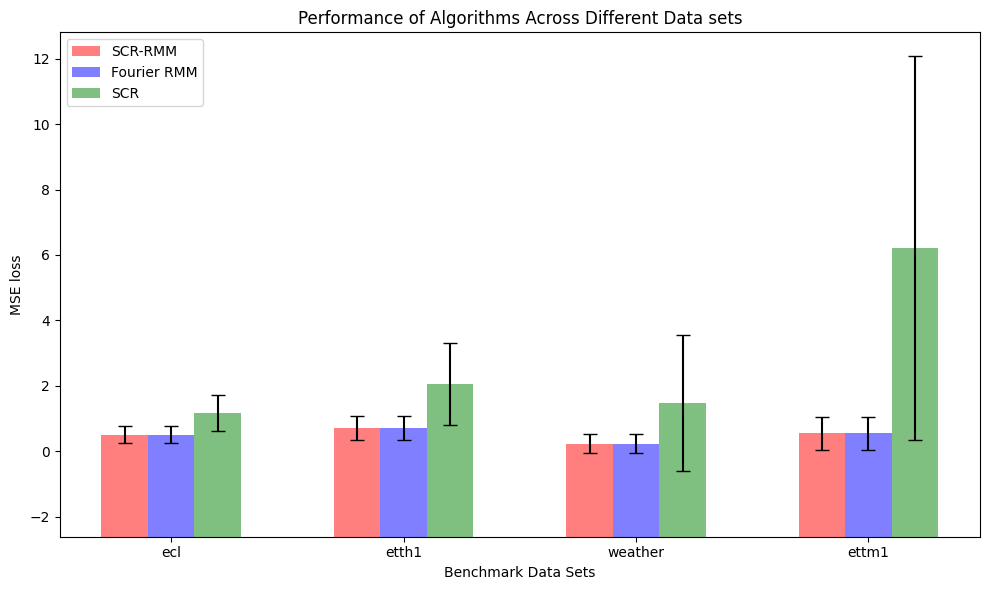

In [29]:
min_val = min(np.min(means_Fourier - std_devs_Fourier), 
              np.min(means_RMM - std_devs_RMM), np.min(means_spRMM - std_devs_spRMM),
             np.min(means_SCR - std_devs_SCR))
y_axis_min = min(0, min_val) - 2

#               ,np.min(means_A3 - std_devs_A3))

# means_A3 = np.mean(A3, axis=1)
# std_devs_A3 = np.std(A3, axis=1)

# Set up the plot
plt.figure(figsize=(10, 6))

x = np.arange(len(data_type))  # x locations for the benchmarks
width = 0.2  # Width of the bars

# plt.bar(x + width, [y_axis_min ]*len(data_type), width=width, color = 'lightblue', alpha = 0.5)

plt.bar(x - width, [y_axis_min ]*len(data_type), width=width, color = 'red', alpha = 0.5)
plt.bar(x, [y_axis_min]*len(data_type), width=width, color='blue', alpha = 0.5)
plt.bar(x + width, [y_axis_min]*len(data_type), width=width, color='green', alpha = 0.5)
# plt.bar(x + 3* width, [y_axis_min]*len(data_type), width=width, color='orange', alpha = 0.5)


# Creating bar plots for each algorithm
# plt.bar(x + width, means_spRMM, width=width, yerr=std_devs_spRMM, capsize=5, label='SCR-RMM-0.98', color = 'lightblue', alpha = 0.5)

plt.bar(x - width, means_RMM, width=width, yerr=std_devs_RMM, capsize=5, label='SCR-RMM', color = 'red', alpha = 0.5)
plt.bar(x, means_Fourier, width=width, yerr=std_devs_Fourier, capsize=5, label='Fourier RMM', color='blue', alpha = 0.5)
plt.bar(x + width, means_SCR, width=width, yerr=std_devs_SCR, capsize=5, label='SCR', color='green', alpha = 0.5)
# plt.bar(x + 3* width, means_SCR_sp, width=width, yerr=std_devs_SCR_sp, capsize=5, label='SCR-0.98', color='orange', alpha = 0.5)

# Setting the x-axis labels and title
plt.xticks(x, data_type)
plt.xlabel('Benchmark Data Sets')
plt.ylabel('MSE loss')
# plt.yscale('log')
plt.title('Performance of Algorithms Across Different Data sets')
plt.ylim(bottom=y_axis_min)

plt.legend()
plt.savefig('results/performance_bars')

# Show the plot
plt.tight_layout()
plt.show()
